#Import

In [86]:
import time
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch
import pandas as pd
import matplotlib.pyplot as plt

##Data PreProcessing

In [87]:
df  = pd.read_csv("dataset/iris.data", index_col = None, header=None)
df.columns = ['x1','x2','x3','x4','y']

d = {'Iris-versicolor':1,'Iris-virginica':2,'Iris-setosa':0}
df['y'] = df['y'].map(d)

X = torch.tensor(df[['x2','x4']].values, dtype= torch.float)
y = torch.tensor(df['y'].values , dtype = torch.float)

In [88]:
torch.manual_seed(123)
shuffleIdx = torch.randperm(y.size(0) ,  dtype = torch.long)

X, y = X[shuffleIdx], y[shuffleIdx]
percent80 = int(y.size(0) * 0.8)


In [89]:

xTrain , xTest = X[:percent80], X[percent80:]
yTrain , yTest = y[:percent80], y[percent80:]

# xTrain

In [90]:
mu, sigma = xTrain.mean(dim=0) , xTrain.std(dim=0)
xTrain = (xTrain-mu)/sigma
xTest = (xTest-mu)/sigma

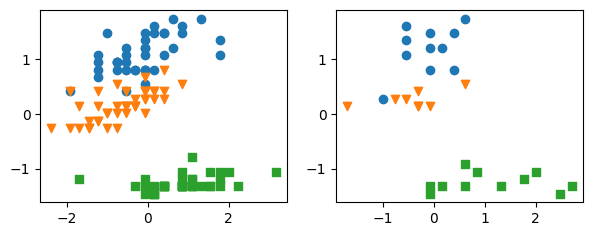

In [91]:
fig, ax = plt.subplots(1,2, figsize=(7,2.5))
ax[0].scatter(xTrain[yTrain==2,0] , xTrain[yTrain==2,1])
ax[0].scatter(xTrain[yTrain==1,0] , xTrain[yTrain==1,1],marker='v')
ax[0].scatter(xTrain[yTrain==0,0] , xTrain[yTrain==0,1],marker='s')
ax[1].scatter(xTest[yTest==2,0] , xTest[yTest==2,1])
ax[1].scatter(xTest[yTest==1,0] , xTest[yTest==1,1],marker='v')
ax[1].scatter(xTest[yTest==0,0] , xTest[yTest==0,1],marker='s')

#API Implementation

In [92]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')

In [93]:
class softmaxRegression(torch.nn.Module):

  def __init__(self,numFeatures,numClasses):
    super(softmaxRegression,self).__init__()
    self.linear = torch.nn.Linear(numFeatures, numClasses)
    self.linear.weight.detach().zero_()
    self.linear.bias.detach().zero_()

  def predict(self,x):
    logits, probas = self.forward(x)
    labels = torch.argmax(probas,dim=1)
    return labels

  def forward(self,x):
    logits = self.linear(x)
    probas = F.softmax(logits,dim=1)
    return logits,probas

  def evaluate(self,x,y):
    pred  = self.predict(x).float()
    acc = torch.sum(pred.view(-1) == y.float()).item() / y.size(0)
    return acc


In [94]:
model = softmaxRegression(2,3).to(DEVICE)
optimizer = torch.optim.SGD(model.parameters(),lr=0.1)


In [95]:
def comp_Accuracy(trueLabels,predLabels):
  acc = torch.sum(trueLabels.view(-1).float()==predLabels.float()).item() / trueLabels.size(0)
  return acc



In [96]:
xTrain = xTrain.to(DEVICE)
yTrain = yTrain.to(DEVICE)
xTest  = xTest.to(DEVICE)
yTest  = yTest.to(DEVICE)

In [97]:
numEpoch = 50

for e in range(numEpoch):

  ##Computing Outputs
  logits, probas = model(xTrain)

  ##Computing Gradients
  cost = F.cross_entropy(logits, yTrain.long())
  optimizer.zero_grad()
  cost.backward()

  ##Update Weights
  optimizer.step()

  ##Logging
  logits,probas = model(xTrain)
  acc = comp_Accuracy(yTrain,torch.argmax(probas,dim=1))
  print('Epoch :%03d' %(e+1), end="")
  print(' | Train ACC: %.3f' % acc, end="")
  print(' | Cost :%.3f' %F.cross_entropy(logits,yTrain.long()))



Epoch :001 | Train ACC: 0.833 | Cost :1.057
Epoch :002 | Train ACC: 0.842 | Cost :1.019
Epoch :003 | Train ACC: 0.842 | Cost :0.984
Epoch :004 | Train ACC: 0.842 | Cost :0.951
Epoch :005 | Train ACC: 0.842 | Cost :0.921
Epoch :006 | Train ACC: 0.842 | Cost :0.894
Epoch :007 | Train ACC: 0.842 | Cost :0.868
Epoch :008 | Train ACC: 0.842 | Cost :0.845
Epoch :009 | Train ACC: 0.850 | Cost :0.823
Epoch :010 | Train ACC: 0.850 | Cost :0.803
Epoch :011 | Train ACC: 0.850 | Cost :0.784
Epoch :012 | Train ACC: 0.850 | Cost :0.767
Epoch :013 | Train ACC: 0.850 | Cost :0.750
Epoch :014 | Train ACC: 0.850 | Cost :0.735
Epoch :015 | Train ACC: 0.850 | Cost :0.721
Epoch :016 | Train ACC: 0.850 | Cost :0.708
Epoch :017 | Train ACC: 0.850 | Cost :0.695
Epoch :018 | Train ACC: 0.850 | Cost :0.684
Epoch :019 | Train ACC: 0.850 | Cost :0.673
Epoch :020 | Train ACC: 0.850 | Cost :0.662
Epoch :021 | Train ACC: 0.850 | Cost :0.652
Epoch :022 | Train ACC: 0.850 | Cost :0.643
Epoch :023 | Train ACC: 0.850 | 

In [98]:
print('\n Model Param \n')
print(' Weights: %s' % model.linear.weight)
print(' Bias: %s' % model.linear.bias)



 Model Param 

 Weights: Parameter containing:
tensor([[ 0.5532, -1.0158],
        [-0.5410,  0.0516],
        [-0.0121,  0.9641]], requires_grad=True)
 Bias: Parameter containing:
tensor([-0.1015,  0.1370, -0.0355], requires_grad=True)


In [99]:
testAcc = model.evaluate(xTest,yTest)
print('Test Accu:',(testAcc * 100))

Test Accu: 90.0


In [100]:
from matplotlib.colors import ListedColormap
import numpy as np

def plotDecisionRegions(X,y,classifier, resolution=0.02):

  markers = ['s','x','o','^','v']
  colors  = ['red','blue','lightgreen','gray','cyan']
  cmap = ListedColormap(colors[:len(np.unique(y))])

  x1min , x1max = X[: ,0].min() -1, X[:,0].max()+1
  x2min , x2max = X[: ,1].min() -1, X[:,1].max()+1
  xx1, xx2 = np.meshgrid(np.arange(x1min,x1max,resolution),
                         np.arange(x2min,x2max,resolution))
  tensor = torch.tensor(np.array([xx1.ravel(),xx2.ravel()]).T).float()
  logits, probas = classifier.forward(tensor)
  z = np.argmax(probas.detach().numpy(),axis=1)
  z = z.reshape(xx1.shape)

  plt.contourf(xx1,xx2,z, alpha=0.4,cmap=cmap)
  plt.xlim(xx1.min(),xx1.max())
  plt.ylim(xx2.min(),xx2.max())

  for idx,cl in enumerate(np.unique(y)):
    plt.scatter(x=X[y==cl,0], y=X[y == cl,1],
                alpha=0.8,color=cmap(idx),
                edgecolor = 'black',
                marker = markers[idx],
                label = cl)

<ipython-input-100-252ace65f377>:24: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y==cl,0], y=X[y == cl,1],


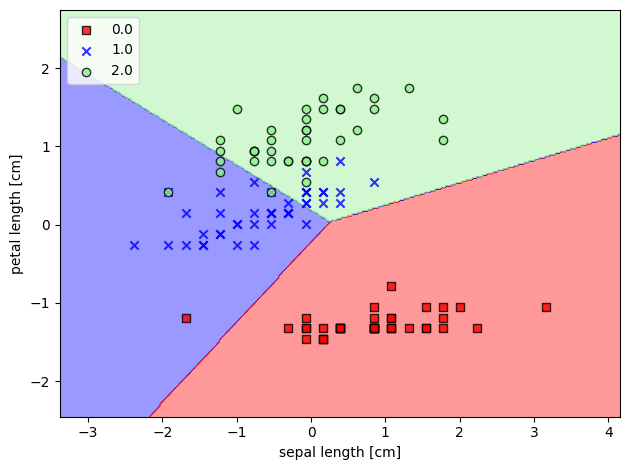

In [101]:
plotDecisionRegions(xTrain,yTrain,classifier=model)
plt.xlabel('sepal length [cm]')
plt.ylabel('petal length [cm]')
plt.legend(loc= 'upper left')

plt.tight_layout()
plt.show()